In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [5]:
filepath = "./OSMI.csv" #loading the original data
try:
    osmi_data = pd.read_csv(filepath)
except Exception as e:
    print(f"Error loading the file: {e}")

In [6]:
# Extracting the relevant features based on the paper
selected_features = [
    'Was your employer primarily a tech company/organization?',
    'What is your age?',
    'What is your gender?',
    'Do you have a family history of mental illness?',
    'Have you had a mental health disorder in the past?',
    'Does your employer provide mental health benefits as part of healthcare coverage?',
    'Have you ever discussed your mental health with your employer?',
]

# Adding target variable
target_variable = 'Do you *currently* have a mental health disorder?'

# Selecting the features and target variable
required_columns = selected_features + [target_variable]

try:
    data_subset = osmi_data[required_columns]
    data_subset.to_csv('filtered_data.csv', index=False)
    print("Filtered data successfully saved as 'filtered_data.csv'")
except KeyError as e:
    print(f"Error: Missing columns in dataset - {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Filtered data successfully saved as 'filtered_data.csv'


In [7]:
# Load the dataset with simplified error handling
try:
    data = pd.read_csv('filtered_data.csv')
    print("Dataset shape:", data.shape)  # Display the shape of the dataset
except Exception as e:
    print(f"Error loading the file: {e}")


Dataset shape: (352, 8)


In [8]:
# Replace variations of "Don't know" with NaN
try:
    dont_know_variations = ["Don't Know", "I don't know", "i don't know", "don't know"]
    data.replace(dont_know_variations, np.nan, inplace=True)
except Exception as e:
    print(f"Error replacing 'Don't know' values: {e}")

# Normalize "Yes" values (case-insensitive and minor spelling errors) to "Yes"
try:
    yes_variations = ["Yes", "yes", "YES", "yEs", "YeS", "Yess", "Yesss"]
    data.replace(yes_variations, "Yes", inplace=True)
except Exception as e:
    print(f"Error normalizing 'Yes' values: {e}")

# Normalize "No" values (case-insensitive variations) to "No"
try:
    no_variations = ["No", "no", "NO", "nO"]
    data.replace(no_variations, "No", inplace=True)
except Exception as e:
    print(f"Error normalizing 'No' values: {e}")

# Check the cleaned data's shape and preview
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 8 columns):
 #   Column                                                                             Non-Null Count  Dtype 
---  ------                                                                             --------------  ----- 
 0   Was your employer primarily a tech company/organization?                           296 non-null    object
 1   What is your age?                                                                  352 non-null    int64 
 2   What is your gender?                                                               345 non-null    object
 3   Do you have a family history of mental illness?                                    266 non-null    object
 4   Have you had a mental health disorder in the past?                                 325 non-null    object
 5   Does your employer provide mental health benefits as part of healthcare coverage?  217 non-null    object
 6   Hav

In [9]:
#Imputing missing values
try:
    # Step 1: Drop rows with NaN values in the target column
    data = data.dropna(subset=['Do you *currently* have a mental health disorder?'])

    # Step 2: Impute "What is your age?" with mean
    if "What is your age?" in data.columns:
        age_imputer = SimpleImputer(strategy='mean')
        data["What is your age?"] = age_imputer.fit_transform(data[["What is your age?"]])

    # Impute remaining columns with the most frequent value
    imputer = SimpleImputer(strategy='most_frequent')
    data.iloc[:, :] = imputer.fit_transform(data)

    # Step 3: Confirm dataset shape and check for missing values
    print(f"Data shape after cleaning: {data.shape}")
    print("Missing values after cleaning:")
    print(data.isnull().sum())
    data.head()
except Exception as e:
    print(f"An error occurred: {e}")

Data shape after cleaning: (326, 8)
Missing values after cleaning:
Was your employer primarily a tech company/organization?                             0
What is your age?                                                                    0
What is your gender?                                                                 0
Do you have a family history of mental illness?                                      0
Have you had a mental health disorder in the past?                                   0
Does your employer provide mental health benefits as part of healthcare coverage?    0
Have you ever discussed your mental health with your employer?                       0
Do you *currently* have a mental health disorder?                                    0
dtype: int64


In [10]:
# Replace 'Possibly' with NaN, drop in the target column and impute in feature columns
try:
    data['Do you *currently* have a mental health disorder?'] = data['Do you *currently* have a mental health disorder?'].replace('Possibly', pd.NA)
    data.dropna(subset=['Do you *currently* have a mental health disorder?'], inplace=True)
except KeyError:
    print("Error: The column 'Do you *currently* have a mental health disorder?' is missing from the dataset.")

# List of columns that could contain 'Possibly' values
columns_with_possibly = [
    'Was your employer primarily a tech company/organization?',
    'Do you have a family history of mental illness?',
    'Have you had a mental health disorder in the past?',
    'Does your employer provide mental health benefits as part of healthcare coverage?',
    'Have you ever discussed your mental health with your employer?'
]

# Replace 'Possibly' with NaN in these columns and impute with mode
for col in columns_with_possibly:
    try:
        data[col] = data[col].replace('Possibly', pd.NA)
        # Impute NaN values with the mode
        data[col].fillna(data[col].mode()[0])
    except KeyError:
        print(f"Error: The column '{col}' is missing from the dataset.")


In [11]:
# Mapping Gender and Binary Columns 
try:
    # 1. Gender Mapping (Male=1, Female=0)
    if 'What is your gender?' in data.columns:
        # Replace variations of gender values to standardize
        data['What is your gender?'] = data['What is your gender?'].replace({'male': 'Male', 'm': 'Male', 'female': 'Female'})
        data['What is your gender?'] = data['What is your gender?'].map({'Male': 1, 'Female': 0})
        
        # Impute NaN values with the mode for gender
        data['What is your gender?'].fillna(data['What is your gender?'].mode()[0], inplace=True)

        # making gender column in integer format
        data['What is your gender?'] = data['What is your gender?'].astype(int)

    # 2. Mapping Binary Columns ('Yes' to 1 and 'No' to 0)
    binary_columns = [
        'Was your employer primarily a tech company/organization?',
        'Do you have a family history of mental illness?',
        'Have you had a mental health disorder in the past?',
        'Does your employer provide mental health benefits as part of healthcare coverage?',
        'Have you ever discussed your mental health with your employer?',
        'Do you *currently* have a mental health disorder?'
    ]

    binary_mapping = {'Yes': 1, 'No': 0, True: 1, False: 0}

    # Map 'Yes'/'No' to 1/0 for all binary columns
    for col in binary_columns:
        if col in data.columns:
            data[col] = data[col].map(binary_mapping)
            # Impute NaN values with the mode for binary columns
            data[col].fillna(data[col].mode()[0], inplace=True)
            # Ensure all binary columns are in integer format (1 and 0)
            data[col] = data[col].astype(int)

    # 3. Final Check after Mapping
    print("After Mapping Gender and Binary Columns (with integer values):")

except Exception as e:
    print(f"An error occurred: {e}")
data.head()

After Mapping Gender and Binary Columns (with integer values):


,Was your employer primarily a tech company/organization?,What is your age?,What is your gender?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Does your employer provide mental health benefits as part of healthcare coverage?,Have you ever discussed your mental health with your employer?,Do you *currently* have a mental health disorder?
2,1,27.0,1,1,0,1,0,0
3,1,37.0,1,1,0,1,0,0
4,1,46.0,1,0,0,1,0,0
5,1,36.0,0,1,1,1,0,1
6,0,39.0,0,1,1,1,0,1


In [12]:
from sklearn.preprocessing import MinMaxScaler

try:
    # 1. Convert 'What is your age?' to numeric, invalid values become NaN
    data['What is your age?'] = pd.to_numeric(data['What is your age?'], errors='coerce')
    # 3. Apply MinMax Scaling to 'What is your age?' column (normalize between 0 and 1)
    scaler = MinMaxScaler()
    data[['What is your age?']] = scaler.fit_transform(data[['What is your age?']])

    # 4. Final check
    print("After Transforming 'What is your age?' column:")
    print(data[['What is your age?']].head())

except Exception as e:
    print(f"An error occurred during age transformation: {e}")
data.to_csv('without_possibly.csv',index=False)
data.shape    

After Transforming 'What is your age?' column:
   What is your age?
2           0.421875
3           0.578125
4           0.718750
5           0.562500
6           0.609375


(251, 8)

### Data Preprocessing & Cleaning done ✅
The preprocessing steps completed, including:
- Handling missing values
- Encoding categorical variables
- Mapping binary columns
- Saving the cleaned dataset for training
The cleaned data is saved as `without_possibly.csv`, and the model training begins in the next section.

In [13]:
try:
    data = pd.read_csv('without_possibly.csv')
    print("Dataset shape:", data.shape)  # Display the shape of the dataset
except Exception as e:
    print(f"Error loading the file: {e}")
data.head()

Dataset shape: (251, 8)


,Was your employer primarily a tech company/organization?,What is your age?,What is your gender?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Does your employer provide mental health benefits as part of healthcare coverage?,Have you ever discussed your mental health with your employer?,Do you *currently* have a mental health disorder?
0,1,0.421875,1,1,0,1,0,0
1,1,0.578125,1,1,0,1,0,0
2,1,0.718750,1,0,0,1,0,0
3,1,0.562500,0,1,1,1,0,1
4,0,0.609375,0,1,1,1,0,1


In [14]:
#Imports for all models and performance metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
# Train-test spilit just to check but will be done by cross validation
try:
    # Separate the target variable ('Do you *currently* have a mental health disorder?') from the features
    X = data.drop(columns=['Do you *currently* have a mental health disorder?'])
    y = data['Do you *currently* have a mental health disorder?']

    # Split the dataset into training and testing sets (e.g., 80% for training, 20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error during train-test split: {e}")


### Model Training Using Cross-Validation 🎯
now training the models using **cross-validation**, which provides a more reliable evaluation of performance.  
This is the **final training approach** chosen for the report.


In [16]:
#1. KNN model training with cross validastion
try:
    
    # Initialize KNN model with grid search result of optimal parameters 
    knn = KNeighborsClassifier(leaf_size= 20, metric='euclidean', n_neighbors= 5, weights= 'uniform') # Once I know the best parameters I just use and removed grid search
    # Perform cross-validation again with the best parameters found
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_knn_tuned = cross_validate(knn, X, y, cv=5, scoring=scoring)

    # Output results for each metric
    print("\nK-Nearest Neighbors (Tuned) K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results_knn_tuned['test_accuracy'])
    print("Precision:", cv_results_knn_tuned['test_precision'])
    print("Recall:", cv_results_knn_tuned['test_recall'])
    print("F1 Score:", cv_results_knn_tuned['test_f1'])

    # Print the mean of each metric
    print("\nK-Nearest Neighbors (Tuned) Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results_knn_tuned['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results_knn_tuned['test_precision']))
    print("Mean Recall:", np.mean(cv_results_knn_tuned['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results_knn_tuned['test_f1']))

except ValueError as e:
    print(f"ValueError: {e}. Please check the parameter grid and dataset compatibility.")
except Exception as e:
    print(f"Error during Grid Search or Cross Validation: {e}")



K-Nearest Neighbors (Tuned) K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.9       0.8       0.84      0.84     ]
Precision: [0.84848485 0.875      0.75675676 0.8        0.82352941]
Recall: [0.93333333 0.96551724 0.96551724 0.96551724 0.93333333]
F1 Score: [0.88888889 0.91803279 0.84848485 0.875      0.875     ]

K-Nearest Neighbors (Tuned) Mean Scores:
Mean Accuracy: 0.848549019607843
Mean Precision: 0.8207542034012623
Mean Recall: 0.9526436781609195
Mean F1 Score: 0.8810813048517968


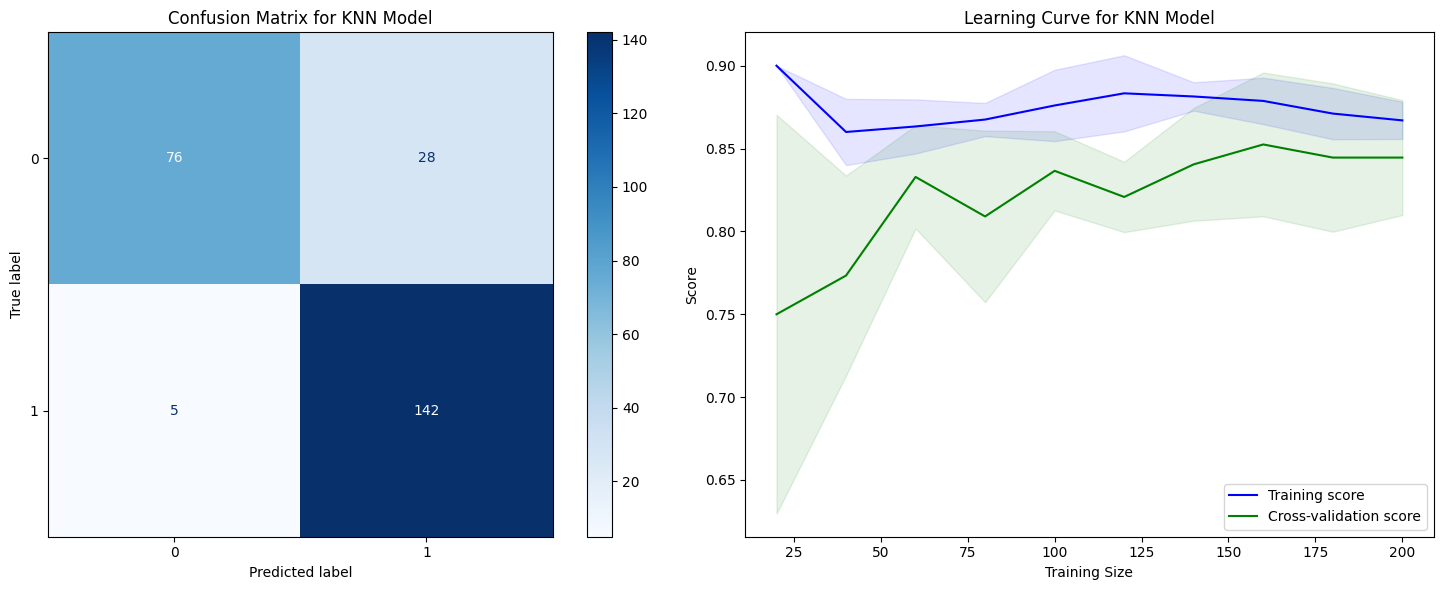

In [17]:
#Plotting a confusion matrix and learning curve for Knn
# Fit the model before plotting (using the best hyperparameters or the ones you have)
knn.fit(X, y)

# 1. Confusion Matrix
y_pred = knn.predict(X)  # Predict using the trained model
cm = confusion_matrix(y, y_pred)  # Generate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Display the confusion matrix

# 2. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(knn, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
# Calculate mean and std of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create a 1x2 plot (2 subplots in one container)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Confusion Matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title("Confusion Matrix for KNN Model")

# Plot Learning Curve on the second subplot
axs[1].plot(train_sizes, train_mean, label="Training score", color="blue")
axs[1].plot(train_sizes, test_mean, label="Cross-validation score", color="green")
axs[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
axs[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
axs[1].set_title("Learning Curve for KNN Model")
axs[1].set_xlabel("Training Size")
axs[1].set_ylabel("Score")
axs[1].legend()

# Show both plots
plt.tight_layout()
plt.show()


In [18]:
#2. SVM model cross validation agian with optimal parameters I got using grid search
try:
    # Initialize SVM model with best parameters
    svm = SVC( C= 10, degree= 3, gamma= 'scale', kernel='rbf',random_state=42)
    # Perform cross-validation again with the best parameters found
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_svm_tuned = cross_validate(svm, X, y, cv=5, scoring=scoring)

    # Output results for each metric
    print("\nSupport Vector Machine (Tuned) K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results_svm_tuned['test_accuracy'])
    print("Precision:", cv_results_svm_tuned['test_precision'])
    print("Recall:", cv_results_svm_tuned['test_recall'])
    print("F1 Score:", cv_results_svm_tuned['test_f1'])

    # Print the mean of each metric
    print("\nSupport Vector Machine (Tuned) Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results_svm_tuned['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results_svm_tuned['test_precision']))
    print("Mean Recall:", np.mean(cv_results_svm_tuned['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results_svm_tuned['test_f1']))

except ValueError as e:
    print(f"ValueError: {e}. Please check the parameter grid and dataset compatibility.")
except Exception as e:
    print(f"Error during Grid Search or Cross Validation: {e}")



Support Vector Machine (Tuned) K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.9       0.82      0.84      0.82     ]
Precision: [0.84848485 0.875      0.77777778 0.8        0.81818182]
Recall: [0.93333333 0.96551724 0.96551724 0.96551724 0.9       ]
F1 Score: [0.88888889 0.91803279 0.86153846 0.875      0.85714286]

Support Vector Machine (Tuned) Mean Scores:
Mean Accuracy: 0.848549019607843
Mean Precision: 0.8238888888888889
Mean Recall: 0.945977011494253
Mean F1 Score: 0.8801205988910906


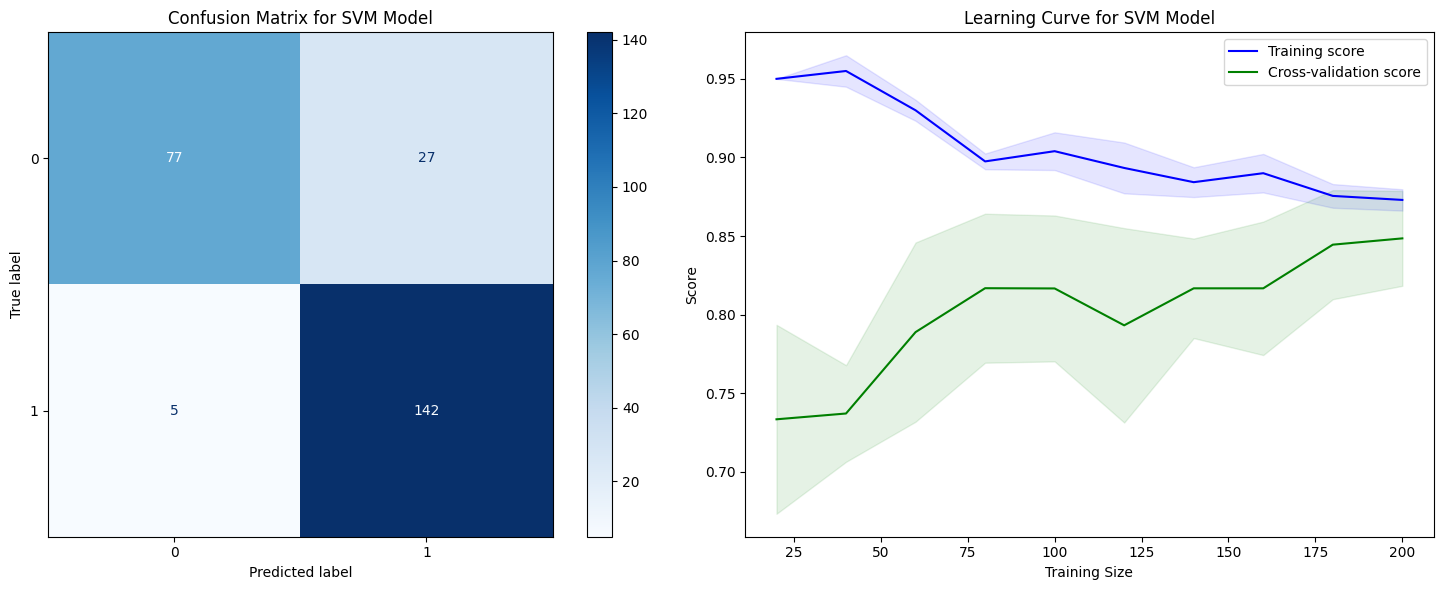

In [19]:
# Confusion matrix and Learning curve for SVM
# 1. Fit the SVM model
svm.fit(X, y)

# 2. Confusion Matrix
y_pred = svm.predict(X)  # Predict using the trained model
cm = confusion_matrix(y, y_pred)  # Generate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Display the confusion matrix

# 3. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(svm, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and std of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create a 1x2 plot (2 subplots in one container)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Confusion Matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title("Confusion Matrix for SVM Model")

# Plot Learning Curve on the second subplot
axs[1].plot(train_sizes, train_mean, label="Training score", color="blue")
axs[1].plot(train_sizes, test_mean, label="Cross-validation score", color="green")
axs[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
axs[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
axs[1].set_title("Learning Curve for SVM Model")
axs[1].set_xlabel("Training Size")
axs[1].set_ylabel("Score")
axs[1].legend()

# Show both plots
plt.tight_layout()
plt.show()


In [20]:
# Gtid search tofind best parameters for logistic regression
# Define the parameter grid
param_grid = {
    'class_weight': [None, 'balanced', {0: 1, 1: 2}],  # Try different class weights
    'C': [0.1, 1, 10],  # Regularization strength
    'max_iter': [100, 200, 300]  # Number of iterations
}

# Initialize Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output the best parameters and cross-validation results
print("Best Parameters:", best_params)


Best Parameters: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'max_iter': 100}


In [21]:
#3. Logistic regression model with cross validation
try:
    # Initialize Logistic Regression model
    logreg = LogisticRegression(max_iter=300, C=1,class_weight={0: 1, 1: 1.3},random_state=42, penalty='l2')

    # Perform K-Fold Cross Validation (e.g., 5 folds) and include multiple metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_logreg = cross_validate(logreg, X, y, cv=5, scoring=scoring)

    # Output results for each metric
    print("Logistic Regression K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results_logreg['test_accuracy'])
    print("Precision:", cv_results_logreg['test_precision'])
    print("Recall:", cv_results_logreg['test_recall'])
    print("F1 Score:", cv_results_logreg['test_f1'])

    # Print the mean of each metric
    print("\nLogistic Regression Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results_logreg['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results_logreg['test_precision']))
    print("Mean Recall:", np.mean(cv_results_logreg['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results_logreg['test_f1']))

except Exception as e:
    print(f"Error during cross-validation: {e}")



Logistic Regression K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.92      0.8       0.84      0.8      ]
Precision: [0.81081081 0.87878788 0.75675676 0.8        0.79411765]
Recall: [1.         1.         0.96551724 0.96551724 0.9       ]
F1 Score: [0.89552239 0.93548387 0.84848485 0.875      0.84375   ]

Logistic Regression Mean Scores:
Mean Accuracy: 0.8445490196078431
Mean Precision: 0.8080946186828539
Mean Recall: 0.9662068965517243
Mean F1 Score: 0.8796482215024584


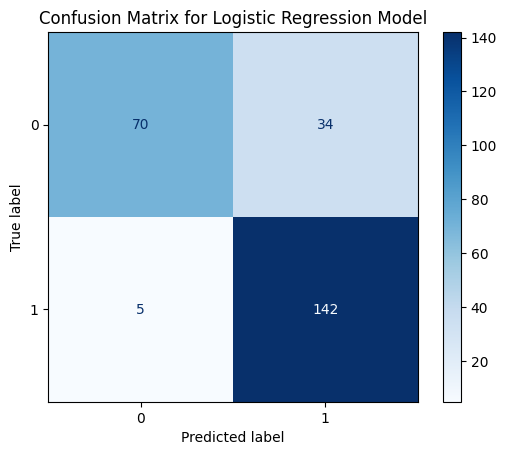

In [22]:
# Logistic regression Confusion matrix
try:
    # 1. Fit the Logistic Regression model
    logreg.fit(X, y)

    # 2. Confusion Matrix
    y_pred = logreg.predict(X)  # Predict using the trained model
    cm = confusion_matrix(y, y_pred)  # Generate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Display the confusion matrix

    # Plot Confusion Matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Logistic Regression Model")
    plt.show()

except Exception as e:
    print(f"Error during Logistic Regression processing: {e}")


In [23]:
#4. Decision tree cross validation
try:
    # Initialize Decision Tree model with parameters I got optimum from grid search
    dt =DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10,min_samples_split=2,max_leaf_nodes=20, class_weight={0: 1, 1: 1})
    # Perform K-Fold Cross Validation (e.g., 5 folds) and include multiple metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_dt = cross_validate(dt, X, y, cv=5, scoring=scoring)

    # Output results for each metric
    print("Decision Tree K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results_dt['test_accuracy'])
    print("Precision:", cv_results_dt['test_precision'])
    print("Recall:", cv_results_dt['test_recall'])
    print("F1 Score:", cv_results_dt['test_f1'])

    # Print the mean of each metric
    print("\nDecision Tree Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results_dt['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results_dt['test_precision']))
    print("Mean Recall:", np.mean(cv_results_dt['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results_dt['test_f1']))

except Exception as e:
    print(f"Error during cross-validation: {e}")


Decision Tree K-Fold Cross Validation Scores:
Accuracy: [0.80392157 0.86       0.8        0.84       0.8       ]
Precision: [0.8125     0.89285714 0.75675676 0.8        0.79411765]
Recall: [0.86666667 0.86206897 0.96551724 0.96551724 0.9       ]
F1 Score: [0.83870968 0.87719298 0.84848485 0.875      0.84375   ]

Decision Tree Mean Scores:
Mean Accuracy: 0.8207843137254901
Mean Precision: 0.8112463093345446
Mean Recall: 0.9119540229885057
Mean F1 Score: 0.8566275016720688


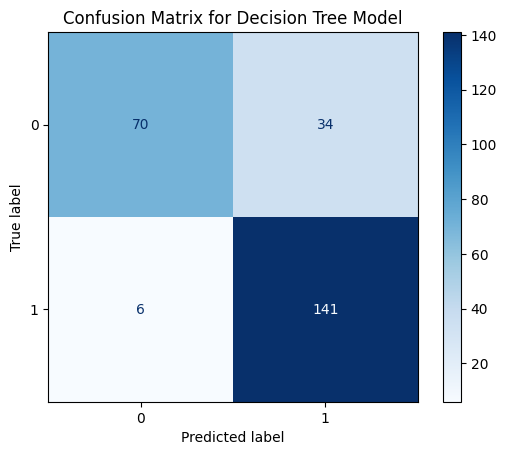

In [24]:
# Decision Tree model with confusion matrix
try:
    # Initialize Decision Tree model with optimal parameters from grid search
    dt = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10,
                                min_samples_split=2, max_leaf_nodes=20, class_weight={0: 1, 1: 1})

    # 1. Fit the Decision Tree model
    dt.fit(X, y)

    # 2. Confusion Matrix
    y_pred = dt.predict(X)  # Predict using the trained model
    cm = confusion_matrix(y, y_pred)  # Generate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Display the confusion matrix
    disp.plot(cmap=plt.cm.Blues)  # Plot the confusion matrix with a blue colormap
    plt.title("Confusion Matrix for Decision Tree Model")
    plt.show()

except Exception as e:
    print(f"Error during Decision Tree processing: {e}")



In [25]:
#5. Random forest model training
# Initialize the model
rf = RandomForestClassifier(random_state=42, class_weight='balanced',max_features= 'sqrt', min_samples_leaf= 4, min_samples_split= 2, n_estimators=50)
# Perform cross-validation with the best model
cv_results_rf = cross_validate(rf, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Output results for each metric
print("Random Forest K-Fold Cross Validation Scores:")
print("Accuracy:", cv_results_rf['test_accuracy'])
print("Precision:", cv_results_rf['test_precision'])
print("Recall:", cv_results_rf['test_recall'])
print("F1 Score:", cv_results_rf['test_f1'])

# Print the mean of each metric
print("\nRandom Forest Mean Scores:")
print("Mean Accuracy:", np.mean(cv_results_rf['test_accuracy']))
print("Mean Precision:", np.mean(cv_results_rf['test_precision']))
print("Mean Recall:", np.mean(cv_results_rf['test_recall']))
print("Mean F1 Score:", np.mean(cv_results_rf['test_f1']))


Random Forest K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.88      0.78      0.8       0.84     ]
Precision: [0.84848485 0.87096774 0.73684211 0.78787879 0.84375   ]
Recall: [0.93333333 0.93103448 0.96551724 0.89655172 0.9       ]
F1 Score: [0.88888889 0.9        0.8358209  0.83870968 0.87096774]

Random Forest Mean Scores:
Mean Accuracy: 0.832549019607843
Mean Precision: 0.8175846967124556
Mean Recall: 0.9252873563218392
Mean F1 Score: 0.8668774407532231


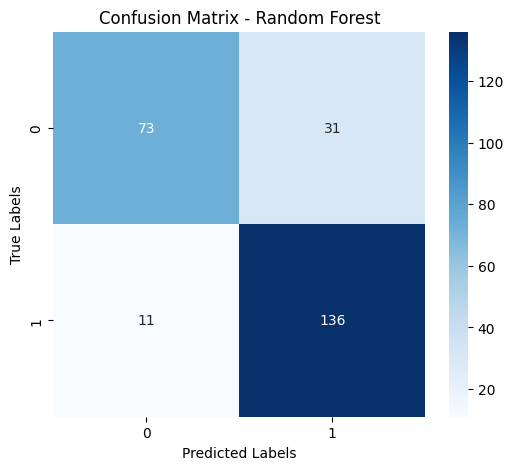

In [26]:
# Random forest confusion matrix
# Get predictions for each fold using cross-validation
y_pred = cross_val_predict(rf, X, y, cv=5)

# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [27]:
#6. Naive bayes model training
# Define the model
naive_bayes = GaussianNB(var_smoothing= np.float64(1.0))
try:

    # Perform K-Fold Cross Validation
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results = cross_validate(rf, X, y, cv=5, scoring=scoring, n_jobs=-1)

    # Output results for each metric
    print("Naive Bayes K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results['test_accuracy'])
    print("Precision:", cv_results['test_precision'])
    print("Recall:", cv_results['test_recall'])
    print("F1 Score:", cv_results['test_f1'])

    # Print the mean of each metric
    print("\nNaive Bayes Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results['test_precision']))
    print("Mean Recall:", np.mean(cv_results['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results['test_f1']))

except Exception as e:
    print(f"Error during cross-validation: {e}")


Naive Bayes K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.88      0.78      0.8       0.84     ]
Precision: [0.84848485 0.87096774 0.73684211 0.78787879 0.84375   ]
Recall: [0.93333333 0.93103448 0.96551724 0.89655172 0.9       ]
F1 Score: [0.88888889 0.9        0.8358209  0.83870968 0.87096774]

Naive Bayes Mean Scores:
Mean Accuracy: 0.832549019607843
Mean Precision: 0.8175846967124556
Mean Recall: 0.9252873563218392
Mean F1 Score: 0.8668774407532231


Here in the Naive Bayes and XG boost I tried to see the effect of threshold just to see the impact

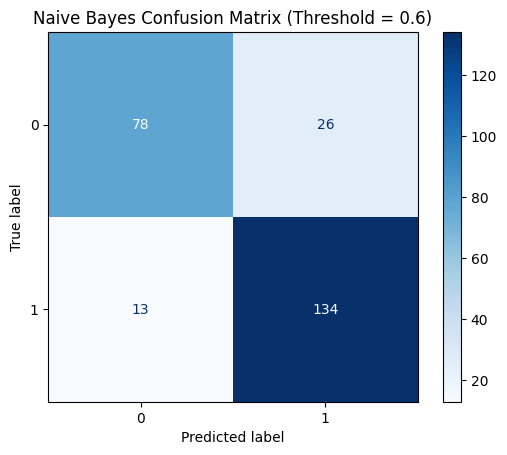

In [30]:
# Confusion matrix with threshold adjustment
naive_bayes.fit(X, y)  # Fit the model with your data

# 2. Predict probabilities for class 1 (positive class)
y_prob = naive_bayes.predict_proba(X)[:, 1]  # Get probabilities for class 1 (positive class)

# 3. Apply threshold (e.g., 0.6)
threshold = 0.6
y_pred_adjusted = (y_prob > threshold).astype(int)  # Apply threshold to get binary predictions

# 4. Compute confusion matrix
cm = confusion_matrix(y, y_pred_adjusted)  # Compute confusion matrix with adjusted predictions
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Create confusion matrix display
disp.plot(cmap=plt.cm.Blues)  # Plot the confusion matrix with a blue color map
plt.title(f"Naive Bayes Confusion Matrix (Threshold = {threshold})")  # Title for the plot
plt.show()  # Display the plot


In [31]:
import xgboost as xgb
# Define the model
xgboost_model = xgb.XGBClassifier(random_state=42)

# Define hyperparameters for optimization
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Set up GridSearchCV to tune the hyperparameters
grid_search_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

try:
    # Perform GridSearchCV to find the best parameter
    grid_search_xgb.fit(X, y)
    print("Best Hyperparameters:", grid_search_xgb.best_params_)

    # Use best model from GridSearch for cross-validation
    best_model_xgb = grid_search_xgb.best_estimator_

    # Perform K-Fold Cross Validation
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_xgb = cross_validate(best_model_xgb, X, y, cv=5, scoring=scoring, n_jobs=-1)

    # Output results for each metric
    print("XGBoost K-Fold Cross Validation Scores:")
    print("Accuracy:", cv_results_xgb['test_accuracy'])
    print("Precision:", cv_results_xgb['test_precision'])
    print("Recall:", cv_results_xgb['test_recall'])
    print("F1 Score:", cv_results_xgb['test_f1'])

    # Print the mean of each metric
    print("\nXGBoost Mean Scores:")
    print("Mean Accuracy:", np.mean(cv_results_xgb['test_accuracy']))
    print("Mean Precision:", np.mean(cv_results_xgb['test_precision']))
    print("Mean Recall:", np.mean(cv_results_xgb['test_recall']))
    print("Mean F1 Score:", np.mean(cv_results_xgb['test_f1']))

except Exception as e:
    print(f"Error during XGBoost cross-validation: {e}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
XGBoost K-Fold Cross Validation Scores:
Accuracy: [0.8627451 0.9       0.8       0.84      0.8      ]
Precision: [0.81081081 0.875      0.75675676 0.8        0.79411765]
Recall: [1.         0.96551724 0.96551724 0.96551724 0.9       ]
F1 Score: [0.89552239 0.91803279 0.84848485 0.875      0.84375   ]

XGBoost Mean Scores:
Mean Accuracy: 0.840549019607843
Mean Precision: 0.8073370429252782
Mean Recall: 0.9593103448275864
Mean F1 Score: 0.8761580046859592


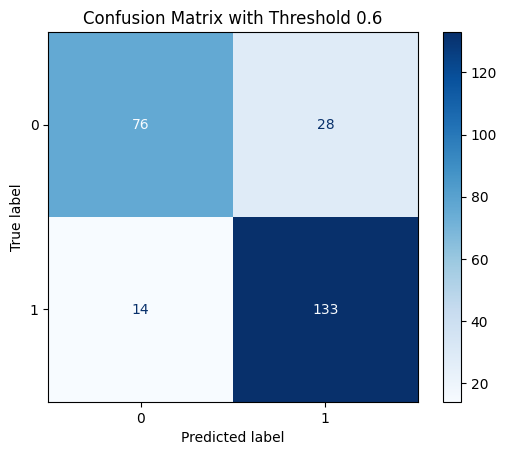

In [32]:
# again for Xg boost with threshold adjustment
# Predict probabilities for the positive class
y_prob_xgb = best_model_xgb.predict_proba(X)[:, 1]  # Get probabilities for class 1 (positive class)

# Use threshold of 0.6
threshold = 0.6
y_pred_adjusted = (y_prob_xgb > threshold).astype(int)  # Convert probabilities to binary predictions

# Generate Confusion Matrix
cm = confusion_matrix(y, y_pred_adjusted)

# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix with Threshold {threshold}")
plt.show()


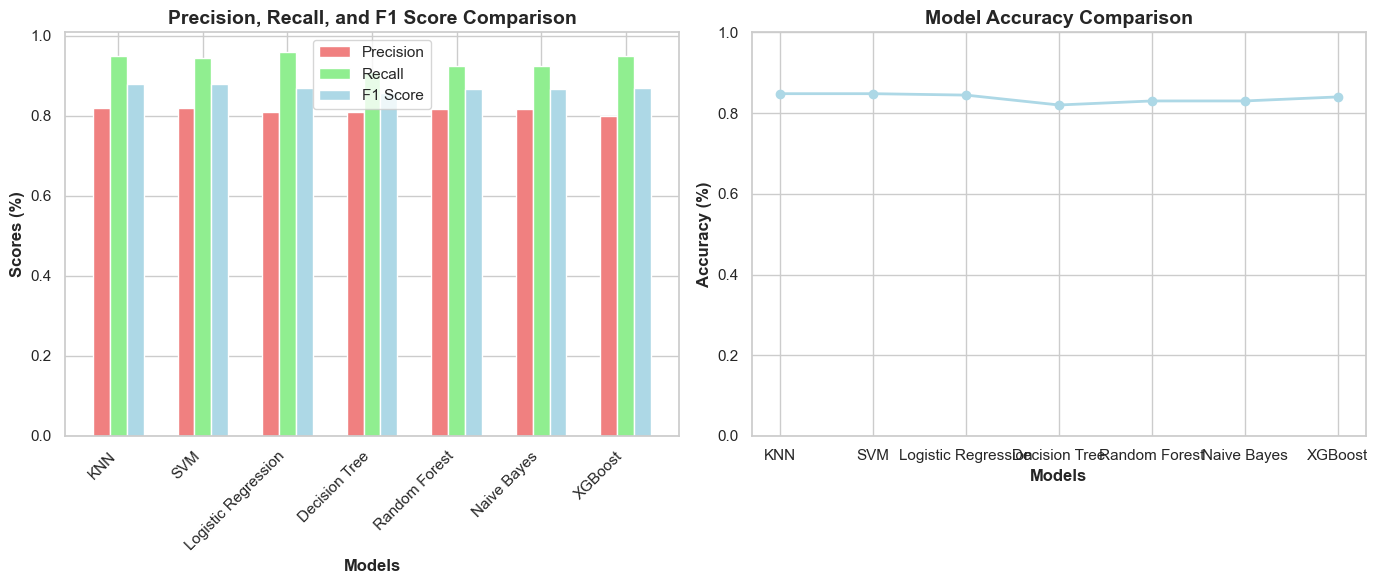

In [47]:
# Comparision of models interms of accuracy and precision recall
# Cross-validation results for each model
models = ['KNN', 'SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost']
accuracy = [0.848, 0.848, 0.8445, 0.82, 0.83, 0.83, 0.84]
precision = [0.82, 0.82, 0.808, 0.81, 0.817, 0.817, 0.80]
recall = [0.95, 0.945, 0.96, 0.91, 0.925, 0.925, 0.95]
f1_score = [0.88, 0.88, 0.87, 0.856, 0.866, 0.866, 0.87]

# 1. Creating 2 side-by-side subplots for Precision, Recall, F1 Score and Accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 2. Plotting Precision, Recall, and F1 Score in a Bar Graph (First subplot)
bar_width = 0.2
index = np.arange(len(models))

# Creating bars for Precision, Recall, and F1 Score
axs[0].bar(index - bar_width, precision, bar_width, label='Precision', color='lightcoral')
axs[0].bar(index, recall, bar_width, label='Recall', color='lightgreen')
axs[0].bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='lightblue')

# Customizing the graph for Precision, Recall, and F1 Score
axs[0].set_xlabel('Models', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Scores (%)', fontsize=12, fontweight='bold')
axs[0].set_title('Precision, Recall, and F1 Score Comparison', fontsize=14, fontweight='bold')
axs[0].set_xticks(index)
axs[0].set_xticklabels(models, rotation=45, ha='right')
axs[0].legend()

# 3. Plotting Accuracy Comparison in a Line Graph (Second subplot)
axs[1].plot(models, accuracy, marker='o', label='Accuracy', color='lightblue', linestyle='-', linewidth=2, markersize=6)

# Customizing the graph for Accuracy
axs[1].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Models', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axs[1].set_ylim(0, 1)  # Scale for percentage (0 to 1)
#axs[1].set_xticklabels(models, rotation=45, ha='right')

# 4. Adjusting layout for better spacing
plt.tight_layout()
plt.show()


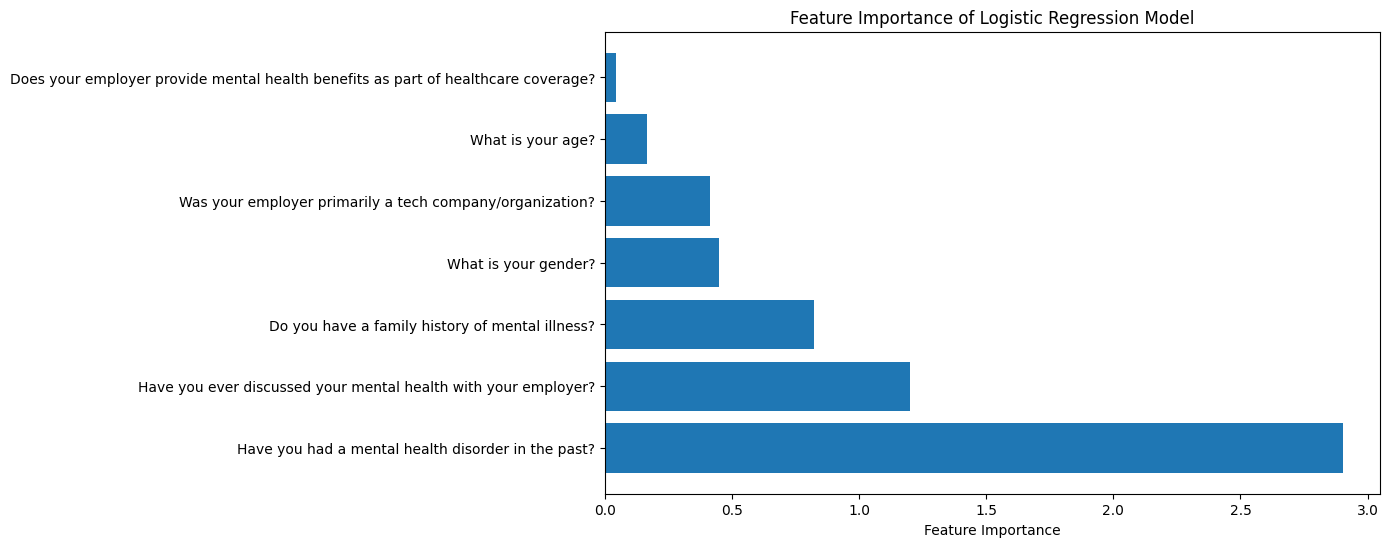

In [33]:
#Feature importance for the second goal of the paper
# Assuming you have already trained your Logistic Regression model
# Logreg model is trained already on X and y
logreg = LogisticRegression(max_iter=300, C=1, class_weight={0: 1, 1: 1.5}, random_state=42, penalty='l2')
logreg.fit(X, y)

# Get feature names (assuming X is a pandas DataFrame)
feature_names = X.columns  # If X is a DataFrame

# Extract the coefficients of the trained model
feature_importance = np.abs(logreg.coef_[0])  # For binary classification, use the first row

# Sort the features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Logistic Regression Model')
plt.show()


### End!



#### Train-Test Split Experimental Approaches (For Reference) ⚠️
Initially, I used a **simple train-test split** for training.  
However, cross-validation was later chosen for better performance evaluation.


In [27]:
#Knn
try:
    # Initialize KNN model
    knn = KNeighborsClassifier(n_neighbors=5,leaf_size= 20, metric= 'euclidean', weights= 'uniform')  

    # Fit the model
    knn.fit(X_train, y_train)

    # Predict on test data
    y_pred_knn = knn.predict(X_test)

    # Evaluate the model
    print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
    print("KNN Precision:", precision_score(y_test, y_pred_knn))
    print("KNN Recall:", recall_score(y_test, y_pred_knn))
    print("KNN F1_Score:", f1_score(y_test, y_pred_knn))

except Exception as e:
    print(f"Error during KNN model training or evaluation: {e}")


KNN Accuracy: 0.7843137254901961
KNN Precision: 0.7142857142857143
KNN Recall: 0.9615384615384616
KNN F1_Score: 0.819672131147541


In [28]:
#SVM model training with train test spilit
try:
    # Initialize Support Vector Machine model
    svm = SVC(kernel='linear')

    # Fit the model
    svm.fit(X_train, y_train)

    # Predict on test data
    y_pred_svm = svm.predict(X_test)

    # Evaluate the model
    print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
    print("SVM Recall:", recall_score(y_test, y_pred_svm))
    print("SVM Precision:", precision_score(y_test, y_pred_svm))
    print("SVM F1_Score:", f1_score(y_test, y_pred_svm))

except Exception as e:
    print(f"Error during SVM model training or evaluation: {e}")


SVM Accuracy: 0.7843137254901961
SVM Recall: 0.9615384615384616
SVM Precision: 0.7142857142857143
SVM F1_Score: 0.819672131147541


In [29]:
#Logistic Regression with validation score
try:
    # Initialize Logistic Regression model
    logreg =LogisticRegression(max_iter=300, C=1,class_weight='balanced',random_state=42, penalty='l2')
    # Fit the model
    logreg.fit(X_train, y_train)

    # Predict on test data
    y_pred_logreg = logreg.predict(X_test)

    # Evaluate the model
    print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
    print("Logistic Regression Recall:", recall_score(y_test, y_pred_logreg))
    print("Logistic Regression Precision:", precision_score(y_test, y_pred_logreg))
    print("Logistic Regression F1_Score:", f1_score(y_test, y_pred_logreg))

except Exception as e:
    print(f"Error during logistic regression model training or evaluation: {e}")


Logistic Regression Accuracy: 0.7450980392156863
Logistic Regression Recall: 0.8461538461538461
Logistic Regression Precision: 0.7096774193548387
Logistic Regression F1_Score: 0.7719298245614035


In [33]:
#3. Decision tree train-test spilit
try:
    # Initialize Decision Tree model
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10, 
                                min_samples_split=2, max_leaf_nodes=20)

    # Fit the model
    dtree.fit(X_train, y_train)

    # Predict on test data
    y_pred_dtree = dtree.predict(X_test)

    # Evaluate the model
    print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dtree))
    print("Decision Tree Precision:", precision_score(y_test, y_pred_dtree))
    print("Decision Tree Recall:", recall_score(y_test, y_pred_dtree))
    print("Decision Tree F1_Score:", f1_score(y_test, y_pred_dtree))

except Exception as e:
    print(f"Error during Decision Tree model training or evaluation: {e}")


Decision Tree Accuracy: 0.6666666666666666
Decision Tree Precision: 0.6666666666666666
Decision Tree Recall: 0.6923076923076923
Decision Tree F1_Score: 0.6792452830188679


In [35]:
#4. Random forest
try:
    # Initialize Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict on test data
    y_pred_rf = rf.predict(X_test)

    # Evaluate the model
    print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
    print("Random Forest Precision:", precision_score(y_test, y_pred_rf))
    print("Random Forest Recall:", recall_score(y_test, y_pred_rf))
    print("Random Forest F1_Score:", f1_score(y_test, y_pred_rf))

except Exception as e:
    print(f"Error during Random Forest model training or evaluation: {e}")


Random Forest Accuracy: 0.6862745098039216
Random Forest Precision: 0.6785714285714286
Random Forest Recall: 0.7307692307692307
Random Forest F1_Score: 0.7037037037037037


In [37]:
#5. Naive Bayes
try:
    # Initialize Naive Bayes model
    nb = GaussianNB()

    # Fit the model
    nb.fit(X_train, y_train)

    # Predict on test data
    y_pred_nb = nb.predict(X_test)

    # Evaluate the model
    print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
    print("Naive Bayes Precision:", precision_score(y_test, y_pred_nb))
    print("Naive Bayes Recall:", recall_score(y_test, y_pred_nb))
    print("Naive Bayes F1_Score:", f1_score(y_test, y_pred_nb))

except Exception as e:
    print(f"Error during Naive Bayes model training or evaluation: {e}")


Naive Bayes Accuracy: 0.7450980392156863
Naive Bayes Precision: 0.7096774193548387
Naive Bayes Recall: 0.8461538461538461
Naive Bayes F1_Score: 0.7719298245614035


In [39]:
# Gradient boosting 
try:
    # Initialize Gradient Boosting model
    gb = GradientBoostingClassifier(n_estimators=10, random_state=42)

    # Fit the model
    gb.fit(X_train, y_train)

    # Predict on test data
    y_pred_gb = gb.predict(X_test)

    # Evaluate the model
    print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
    print("Gradient Boosting Precision:", precision_score(y_test, y_pred_gb))
    print("Gradient Boosting Recall:", recall_score(y_test, y_pred_gb))
    print("Gradient Boosting F1_Score:", f1_score(y_test, y_pred_gb))

except Exception as e:
    print(f"Error during Gradient Boosting model training or evaluation: {e}")



Gradient Boosting Accuracy: 0.7843137254901961
Gradient Boosting Precision: 0.7142857142857143
Gradient Boosting Recall: 0.9615384615384616
Gradient Boosting F1_Score: 0.819672131147541


In [41]:
#7. XG boost
try:
    # Initialize XGBoost model
    xgb = XGBClassifier(n_estimators=100, random_state=42)

    # Fit the model
    xgb.fit(X_train, y_train)

    # Predict on test data
    y_pred_xgb = xgb.predict(X_test)

    # Evaluate the model
    print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
    print("XGBoost Precision:", precision_score(y_test, y_pred_xgb))
    print("XGBoost Recall:", recall_score(y_test, y_pred_xgb))
    print("XGBoost F1_Score:", f1_score(y_test, y_pred_xgb))

except Exception as e:
    print(f"Error during XGBoost model training or evaluation: {e}")


XGBoost Accuracy: 0.6470588235294118
XGBoost Precision: 0.6538461538461539
XGBoost Recall: 0.6538461538461539
XGBoost F1_Score: 0.6538461538461539
